# spectre Benchmarks

In [1]:
import pandas as pd
print('pandas', pd.__version__)
start, end = pd.Timestamp('2013-01-02', tz='UTC'), pd.Timestamp('2018-01-03', tz='UTC')

import sys
sys.path = ['..\\..\\spectre'] + sys.path

from spectre import factors, parallel, data
import pandas as pd
loader = data.ArrowLoader('../../historical_data/us/prices/quandl/wiki_prices.feather')

pandas 1.0.0


In [2]:
engine = factors.FactorEngine(loader)
engine.to_cuda()

In [3]:
engine.remove_all_factors()
engine.add(factors.MA(100), 'ma')
%time dfsp=engine.run(start, end)
dfsp.head(5).append(dfsp.tail(5))

Wall time: 3.47 s


ma
date                      asset           
2013-01-03 00:00:00+00:00 A      38.110535
                          AAL    11.776899
                          AAMC   67.738457
                          AAN    28.779516
                          AAON   19.606133
2018-01-03 00:00:00+00:00 ZIXI    4.827700
                          ZNGA    3.831000
                          ZOES   13.561499
                          ZTS    66.546745
                          ZUMZ   17.383249

In [4]:
%timeit engine.run(start, end)
%timeit -n 3 -r 10 engine.run(start, end)

143 ms ± 1.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
144 ms ± 974 µs per loop (mean ± std. dev. of 10 runs, 3 loops each)


In [5]:
engine.remove_all_factors()
engine.add(factors.EMA(50, adjust=True), 'ema50')
%time dfsp=engine.run(start, end)
dfsp.head(5).append(dfsp.tail(5))

Wall time: 927 ms


ema50
date                      asset           
2013-01-03 00:00:00+00:00 A      38.896118
                          AAL    12.635515
                          AAMC   28.142620
                          AAN    28.474855
                          AAON   20.191982
2018-01-03 00:00:00+00:00 ZIXI    4.585052
                          ZNGA    3.922959
                          ZOES   15.169839
                          ZTS    70.053635
                          ZUMZ   19.615715

In [6]:
%timeit engine.run(start, end)
%timeit -n 3 -r 10 engine.run(start, end)

269 ms ± 1.75 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
270 ms ± 1.89 ms per loop (mean ± std. dev. of 10 runs, 3 loops each)


In [7]:
engine.remove_all_factors()
f = factors.MACD()+factors.RSI()+factors.STOCHF()
engine.add(f.rank().zscore(), 'f')
%time dfsp=engine.run(start, end)
dfsp.head(5).append(dfsp.tail(5))

Wall time: 368 ms


f
date                      asset          
2013-01-03 00:00:00+00:00 A      0.188034
                          AAL    0.995929
                          AAMC   1.311495
                          AAN    0.148885
                          AAON  -0.484618
2018-01-03 00:00:00+00:00 ZIXI   0.100265
                          ZNGA  -1.142462
                          ZOES  -0.713156
                          ZTS   -1.022426
                          ZUMZ  -1.104333

In [8]:
%timeit engine.run(start, end)
%timeit -n 3 -r 10 engine.run(start, end)

281 ms ± 2.55 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
282 ms ± 1.33 ms per loop (mean ± std. dev. of 10 runs, 3 loops each)


In [9]:
import torch
torch.cuda.max_memory_allocated()/1024**3, 'GB'

(2.391538143157959, 'GB')

## Backtesting
--------------------

In [1]:
import sys
sys.path = ['..\\..\\spectre'] + sys.path

from spectre import factors, trading
from spectre.data import ArrowLoader, DataLoaderFastGetter
import pandas as pd

loader = ArrowLoader('../../historical_data/us/prices/quandl/wiki_prices.feather')

import plotly.io as pio
pio.renderers.default = "svg"

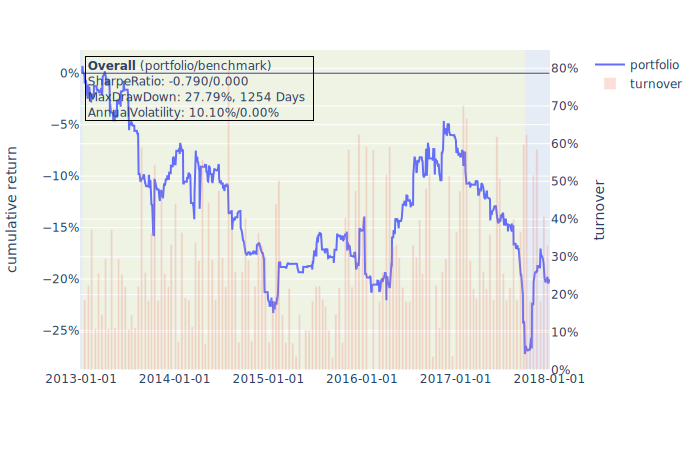

Wall time: 4.7 s


In [3]:
class MyAlg(trading.CustomAlgorithm):
    first_break = True
    def initialize(self):
        # setup engine
        engine = self.get_factor_engine()
        engine.to_cuda()
        universe = factors.AverageDollarVolume(win=120).top(500)
        engine.set_filter(universe)

        # add your factors
        rsi = factors.RSI()
        engine.add( rsi.top(3).shift(1), 'longs' )
        engine.add( rsi.bottom(3).shift(1), 'shorts' )
        
        # schedule rebalance before market close
        self.schedule_rebalance(trading.event.MarketClose(self.rebalance, offset_ns=-10000))

        # simulation parameters
        self.blotter.capital_base = 10000
        self.blotter.max_shares = 1e+19
        self.blotter.set_commission(percentage=0, per_share=0.005, minimum=1)
        # self.blotter.set_slippage(percentage=0, per_share=0.4)

    def rebalance(self, data: 'pd.DataFrame', history: 'pd.DataFrame'):
        if self.first_break:
            self.first_break = False  # Keep consistent with zipline
            return

        all_assets = data.index
        longs = set(all_assets[data.longs])
        shorts = set(all_assets[data.shorts])

        self.record(universe_size=len(all_assets))

        # Build a 2x-leveraged, equal-weight, long-short portfolio.
        one_third = 1.0 / 3.0
        self.blotter.batch_order_target_percent(longs, [one_third]*len(longs))
        self.blotter.batch_order_target_percent(shorts, [-one_third]*len(shorts))
        
        # Remove any assets that should no longer be in our portfolio.
        portfolio_assets = longs | shorts
        positions = self.blotter.portfolio.positions.keys()
        removes = positions - set(portfolio_assets)
        self.blotter.batch_order_target_percent(removes, [0] * len(removes))

    def terminate(self, records: 'pd.DataFrame'):
        self.plot()

%time results = trading.run_backtest(loader, MyAlg, '2013-1-3', '2018-1-3')

In [4]:
import torch
torch.cuda.max_memory_allocated()/1024**3, 'GB'

(2.1984200477600098, 'GB')